# Extract tissue/lineage & prepare input for scVelo, which is Python-based

#### Working directory should contain root atlas Seurat object, which is available on GEO under record GSE152766:

    Root_Atlas.rds (or get it by running through notebook 2, 3, 4, 5, 6 & 7)
    Root_Atlas_spliced_unspliced_raw_counts.rds

In [1]:
rm(list=ls())
# Set the working directory to where folders named after the samples are located. 
# The folder contains spliced.mtx, unspliced.mtx, barcodes and gene id files, and json files produced by scKB that documents the sequencing stats. 
setwd("/scratch/AG_Ohler/CheWei/scKB")

In [2]:
# Load libraries
suppressMessages(library(Seurat))
suppressMessages(library(CytoTRACE))
suppressMessages(library(RColorBrewer))
suppressMessages(library(ggplot2))
suppressMessages(library(grid))

Warning message:
“The ScanoramaCT python module is not accessible. The iCytoTRACE function for integration across multiple datasets will be disabled. Please follow the instructions in https://github.com/gunsagargulati/CytoTRACE to install the necessary Python packages for this application.”


In [3]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /fast/home/c/chsu/anaconda3/envs/seu3/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.utf-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.utf-8        LC_COLLATE=en_US.utf-8    
 [5] LC_MONETARY=en_US.utf-8    LC_MESSAGES=en_US.utf-8   
 [7] LC_PAPER=en_US.utf-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.utf-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ggplot2_3.3.2      RColorBrewer_1.1-2 CytoTRACE_0.1.0    Seurat_3.1.5      

loaded via a namespace (and not attached):
 [1] httr_1.4.2          tidyr_1.1.2         jsonlite_1.7.1     
 [4] viridisLite_0.3.0   splines_4.0.3       leiden_0.3.5       
 [7] ggrepel_0.8.2       global

In [4]:
# Plotting function for cell tyepes and time zone
plot_anno <- function(rc.integrated){
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Metaphloem & Companion Cell","Protophloem", "Xylem", "Procambium","Xylem Pole Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
rc.integrated$celltype.anno <- factor(rc.integrated$celltype.anno, levels = order[sort(match(unique(rc.integrated$celltype.anno),order))]) 
color <- palette[sort(match(unique(rc.integrated$celltype.anno),order))]
p1 <- DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno", cols=color)
p2 <- DimPlot(rc.integrated, reduction = "umap", group.by = "time.anno",order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation","Meristem"),cols = c("#e5f5e0", "#a1d99b", "#31a354", "#deebf7", "#3182bd", "#fee0d2","#de2d26"))
options(repr.plot.width=20, repr.plot.height=8)
gl <- lapply(list(p1, p2), ggplotGrob)
gwidth <- do.call(unit.pmax, lapply(gl, "[[", "widths"))
gl <- lapply(gl, "[[<-", "widths", value = gwidth)
gridExtra::grid.arrange(grobs=gl, ncol=2)
}
zscore <- function(x){(x-mean(x))/sd(x)}

In [5]:
# Read in atlas
rc.integrated <- readRDS('./Root_Atlas.rds')
rc.su.counts <- readRDS('./rc.integrated.su.counts_16WT_110K_DR.rds')

In [6]:
table(rc.integrated$celltype.anno)


           Quiescent Center                   Columella 
                        158                        8535 
           Lateral Root Cap                Atrichoblast 
                      18396                       13380 
                Trichoblast                      Cortex 
                      12361                       11073 
                 Endodermis Metaphloem & Companion Cell 
                      11369                        3224 
                Protophloem                  Procambium 
                        939                        9307 
       Xylem Pole Pericycle       Phloem Pole Pericycle 
                      12213                        4634 
                 Protoxylem                   Metaxylem 
                       3195                        1643 

## 1. Extract Ground Tissue

In [7]:
# Index for ground tissue trajectory
end.cor.traj.idx <- which(rc.integrated$celltype.anno == "Endodermis" | rc.integrated$celltype.anno == "Cortex" | rc.integrated$celltype.anno == "Quiescent Center") 

In [8]:
# Extract ground tissue
end.cor.integrated <- subset(rc.integrated, cells = colnames(rc.integrated)[end.cor.traj.idx])

In [97]:
# Run UMAP
end.cor.integrated <- RunUMAP(end.cor.integrated, reduction = "pca", dims = 1:8, umap.method = "umap-learn", metric = "correlation")

In [99]:
end.cor.integrated[["umap"]]@cell.embeddings[,1] <- end.cor.integrated[["umap"]]@cell.embeddings[,1]*-1
end.cor.integrated[["umap"]]@cell.embeddings[,2] <- end.cor.integrated[["umap"]]@cell.embeddings[,2]*-1
#u2 <- rc.integrated@reductions$umap@cell.embeddings[,1]
#u1 <- rc.integrated@reductions$umap@cell.embeddings[,2]
#rc.integrated@reductions$umap@cell.embeddings[,1] <- u1
#rc.integrated@reductions$umap@cell.embeddings[,2] <- u2

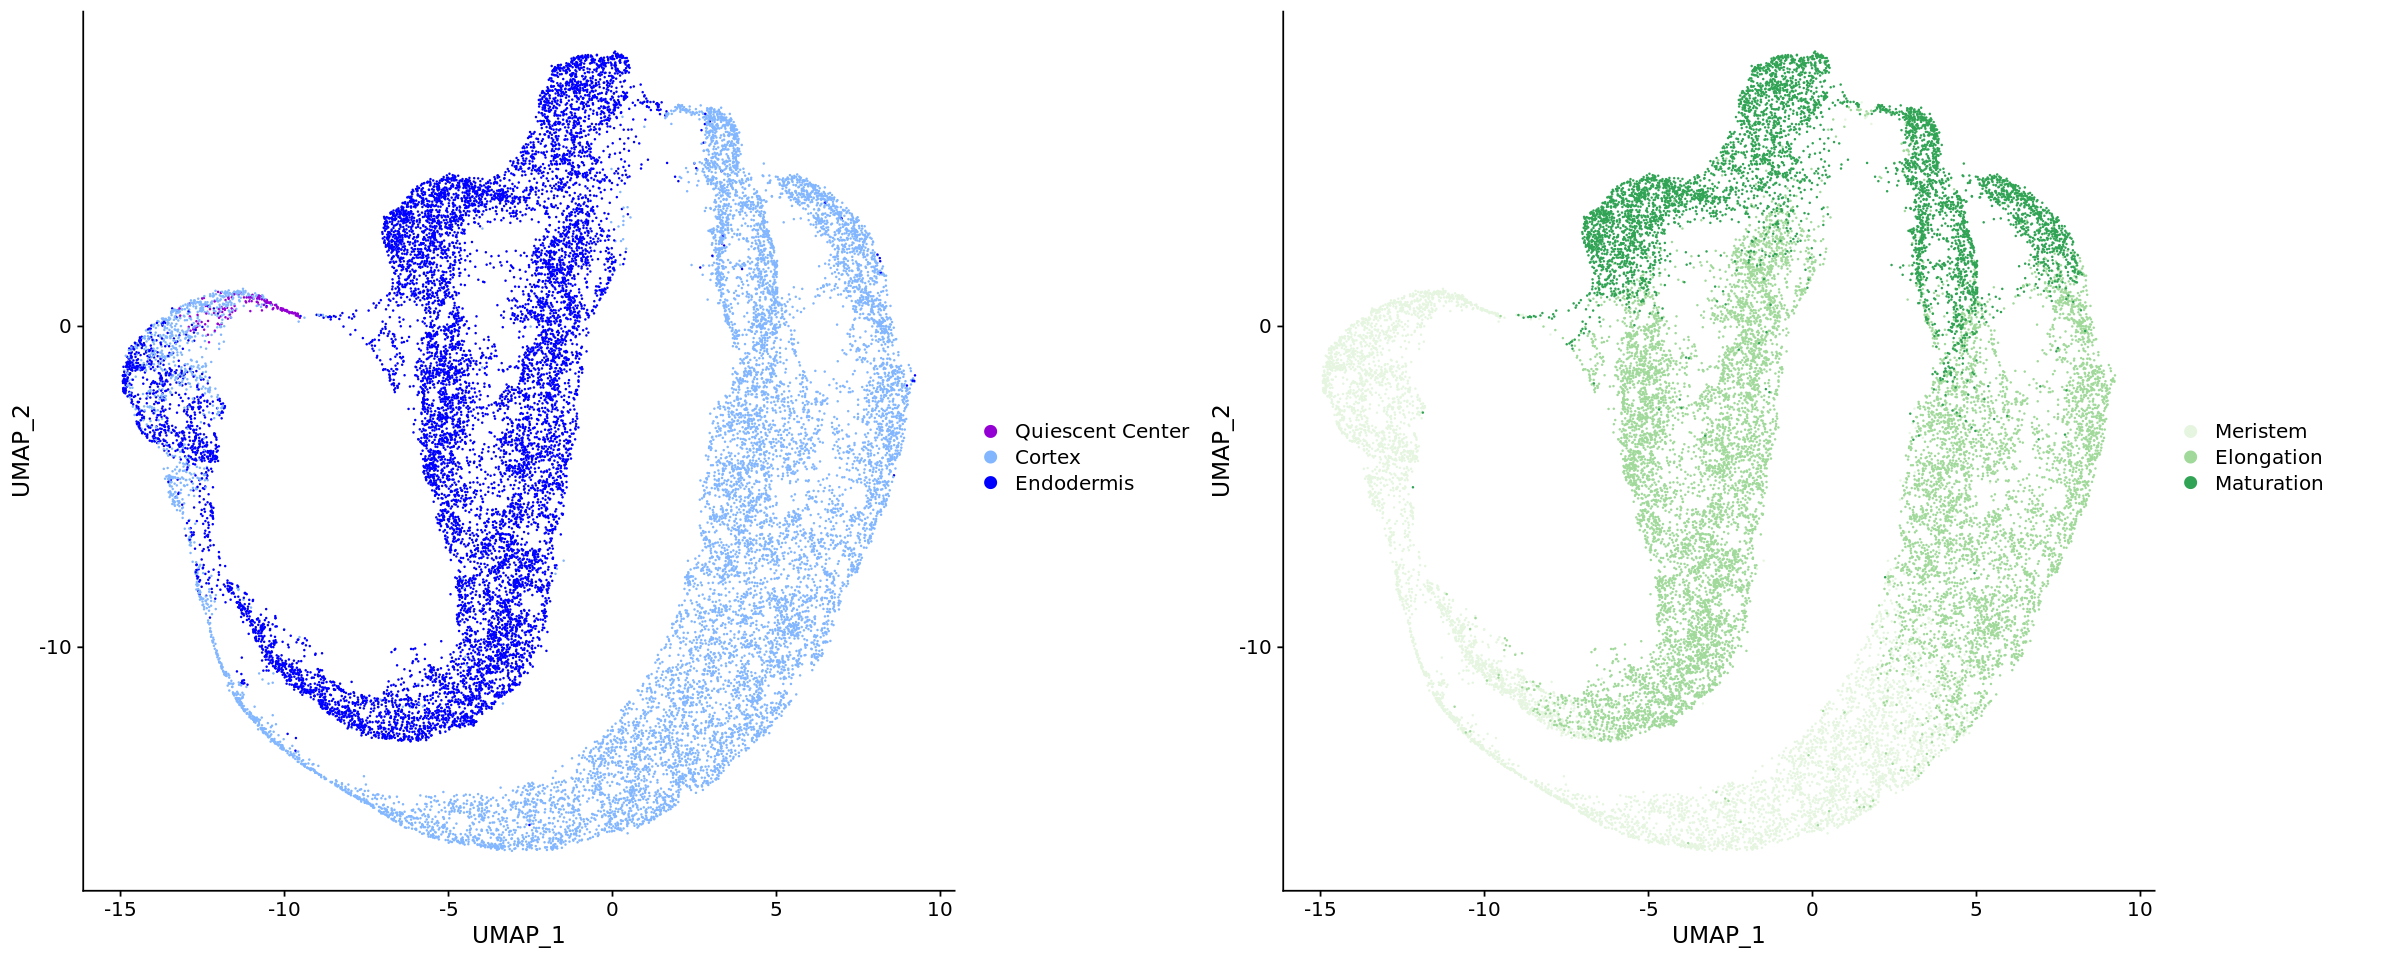

In [100]:
plot_anno(end.cor.integrated)

In [101]:
# Prepare expression matrix for CytoTRACE
expression_matrix <- end.cor.integrated@assays$integrated@data
expression_matrix[which(expression_matrix < 0)]=0
expression_matrix <- as(expression_matrix, "dgCMatrix")
end.cor.integrated@assays$integrated@counts <- expression_matrix

In [102]:
# Run CytoTRACE
results <- CytoTRACE(as.matrix(end.cor.integrated@assays$integrated@counts), ncores = 16, subsamplesize = 1000)
end.cor.integrated$CytoTRACE <- results$CytoTRACE 

The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

CytoTRACE will be run on 23 sub-sample(s) of approximately 983 cells each using 16 / 16 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



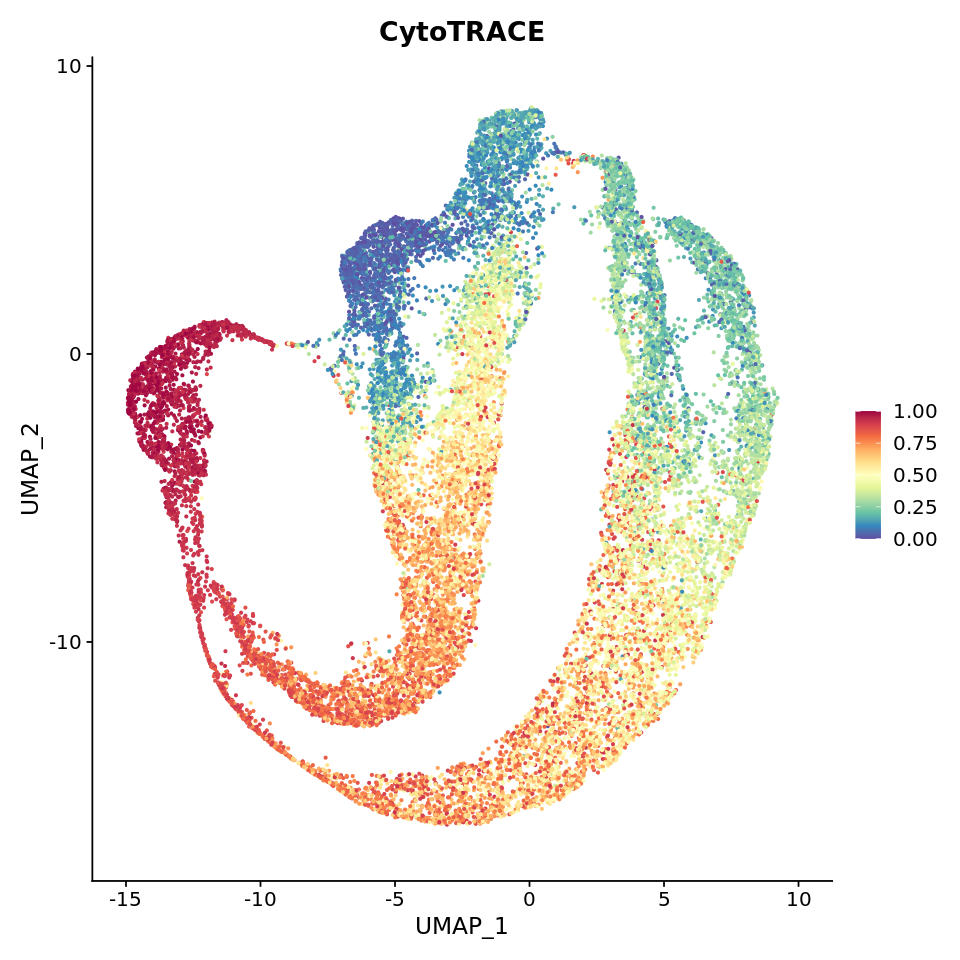

In [103]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(end.cor.integrated, features = "CytoTRACE", pt.size=0.5)+ scale_colour_gradientn(colours = rev(brewer.pal(11,"Spectral")))

In [150]:
# Save Seurat object
saveRDS(end.cor.integrated,'./supp_data/Ground_Tissue_Atlas.rds')

In [151]:
# Prepare scVelo input
rc.su.counts <- subset(rc.su.counts, cells = colnames(rc.su.counts)[end.cor.traj.idx]) 
sr <- rc.su.counts@assays$spliced_RNA@counts
sr <- sr[rownames(end.cor.integrated@assays$integrated@data),]
ur <- rc.su.counts@assays$unspliced_RNA@counts
ur <- ur[rownames(end.cor.integrated@assays$integrated@data),]
ar <- end.cor.integrated@assays$RNA@counts
ar <- ar[rownames(end.cor.integrated@assays$integrated@data),]
sr <- sr/ar;
ur <- ur/ar;
sr <- as.matrix(sr)
ur <- as.matrix(ur)
sr[is.nan(sr)] = 0;
ur[is.nan(ur)] = 0;
colnames(sr) <- colnames(end.cor.integrated)
colnames(ur) <- colnames(end.cor.integrated)
int <- as.matrix(end.cor.integrated@assays$integrated@counts)
spliced <- int*sr;
unspliced <- int*ur;
sg <- intersect(rownames(spliced), rownames(unspliced));
spliced <- spliced[match(sg, rownames(spliced)),];
unspliced <- unspliced[match(sg, rownames(unspliced)),];
meta <- end.cor.integrated@meta.data[,grep("time.anno|celltype.anno|time.celltype.anno|CytoTRACE",colnames(end.cor.integrated@meta.data))];
var <- sg;
pca_int <- end.cor.integrated@reductions$pca@cell.embeddings;
umap_int <- end.cor.integrated@reductions$umap@cell.embeddings;
save(spliced, unspliced, meta, var, pca_int, umap_int, file = "./supp_data/Ground_Tissue_Atlas_scVelo_input.RData")

## 2. Extract Epidermis + LRC

In [7]:
# Index for epidermis + LRC trajectory
end.cor.traj.idx <- which(rc.integrated$celltype.anno == "Quiescent Center" | rc.integrated$celltype.anno == "Atrichoblast" | rc.integrated$celltype.anno == "Trichoblast" | rc.integrated$celltype.anno == "Lateral Root Cap" );
# Extract epidermis + LRC
end.cor.integrated <- subset(rc.integrated, cells = colnames(rc.integrated)[end.cor.traj.idx])
# Run UMAP
end.cor.integrated <- RunUMAP(end.cor.integrated, reduction = "pca", dims = 1:8, umap.method = "umap-learn", metric = "correlation")
plot_anno(end.cor.integrated)

In [8]:
# Prepare expression matrix for CytoTRACE
expression_matrix <- end.cor.integrated@assays$integrated@data
expression_matrix[which(expression_matrix < 0)]=0
expression_matrix <- as(expression_matrix, "dgCMatrix")
end.cor.integrated@assays$integrated@counts <- expression_matrix

In [9]:
# Run CytoTRACE
results <- CytoTRACE(as.matrix(end.cor.integrated@assays$integrated@counts), ncores = 16, subsamplesize = 1000)
end.cor.integrated$CytoTRACE <- results$CytoTRACE 

The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

CytoTRACE will be run on 44 sub-sample(s) of approximately 1007 cells each using 16 / 16 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



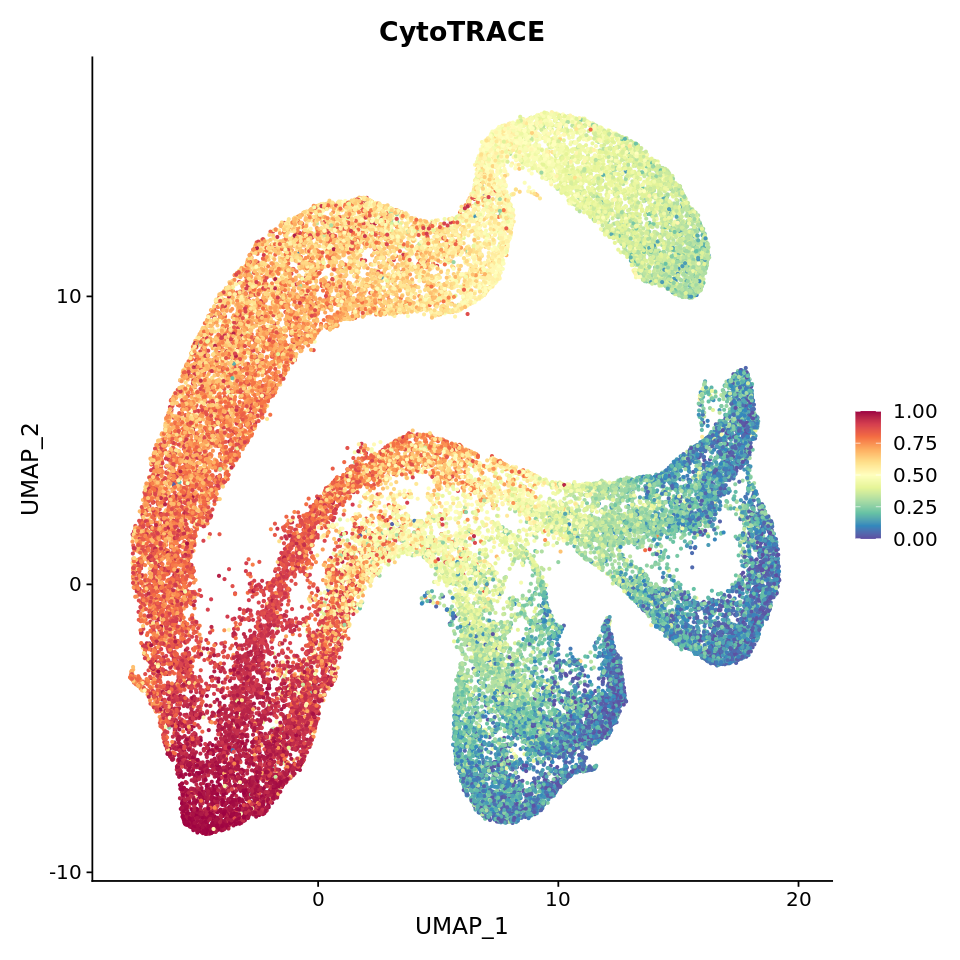

In [10]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(end.cor.integrated, features = "CytoTRACE", pt.size=0.5)+ scale_colour_gradientn(colours = rev(brewer.pal(11,"Spectral")))

In [15]:
saveRDS(end.cor.integrated,'./supp_data/Epidermis_LRC_Atlas.rds')

In [16]:
# Prepare scVelo input
rc.su.counts <- readRDS('./rc.integrated.su.counts_16WT_110K_DR.rds')
rc.su.counts <- subset(rc.su.counts, cells = colnames(rc.su.counts)[end.cor.traj.idx]) 
sr <- rc.su.counts@assays$spliced_RNA@counts
sr <- sr[rownames(end.cor.integrated@assays$integrated@data),]
ur <- rc.su.counts@assays$unspliced_RNA@counts
ur <- ur[rownames(end.cor.integrated@assays$integrated@data),]
ar <- end.cor.integrated@assays$RNA@counts
ar <- ar[rownames(end.cor.integrated@assays$integrated@data),]
sr <- sr/ar;
ur <- ur/ar;
sr <- as.matrix(sr)
ur <- as.matrix(ur)
sr[is.nan(sr)] = 0;
ur[is.nan(ur)] = 0;
colnames(sr) <- colnames(end.cor.integrated)
colnames(ur) <- colnames(end.cor.integrated)
int <- as.matrix(end.cor.integrated@assays$integrated@counts)
#int[which(int < 0)]=0
spliced <- int*sr;
unspliced <- int*ur;
sg <- intersect(rownames(spliced), rownames(unspliced));
spliced <- spliced[match(sg, rownames(spliced)),];
unspliced <- unspliced[match(sg, rownames(unspliced)),];
meta <- end.cor.integrated@meta.data[,grep("time.anno|celltype.anno|time.celltype.anno|CytoTRACE",colnames(end.cor.integrated@meta.data))];
var <- sg;
pca_int <- end.cor.integrated@reductions$pca@cell.embeddings;
umap_int <- end.cor.integrated@reductions$umap@cell.embeddings;
save(spliced, unspliced, meta, var, pca_int, umap_int, file = "./supp_data/Epidermis_LRC_Atlas_scVelo_input.RData")

## 3. Extract Columella

In [17]:
end.cor.traj.idx <- which(rc.integrated$celltype.anno == "Quiescent Center" | rc.integrated$celltype.anno == "Columella");
end.cor.integrated <- subset(rc.integrated, cells = colnames(rc.integrated)[end.cor.traj.idx])
end.cor.integrated <- RunUMAP(end.cor.integrated, reduction = "pca", dims = 1:8, umap.method = "umap-learn", metric = "correlation")
plot_anno_c <- function(rc.integrated){
order <- c("Quiescent Center","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Metaphloem & Companion Cell","Protophloem", "Xylem", "Procambium","Xylem Pole Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400d3","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
rc.integrated$celltype.anno <- factor(rc.integrated$celltype.anno, levels = order[sort(match(unique(rc.integrated$celltype.anno),order))]) 
color <- palette[sort(match(unique(rc.integrated$celltype.anno),order))]
p1 <- DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno", cols=color)
p2 <- DimPlot(rc.integrated, reduction = "umap", group.by = "time.anno",order = c("Distal Columella","Proximal Columella","Meristem"),cols = c("#e5f5e0", '#fee0d2','#de2d26'))
options(repr.plot.width=20, repr.plot.height=8)
gl <- lapply(list(p1, p2), ggplotGrob)
gwidth <- do.call(unit.pmax, lapply(gl, "[[", "widths"))
gl <- lapply(gl, "[[<-", "widths", value = gwidth)
gridExtra::grid.arrange(grobs=gl, ncol=2)
}

In [18]:
end.cor.integrated[["umap"]]@cell.embeddings[,1] <- end.cor.integrated[["umap"]]@cell.embeddings[,1]*-1
end.cor.integrated[["umap"]]@cell.embeddings[,2] <- end.cor.integrated[["umap"]]@cell.embeddings[,2]*-1

In [19]:
plot_anno_c(end.cor.integrated)

In [20]:
expression_matrix <- end.cor.integrated@assays$integrated@data
expression_matrix[which(expression_matrix < 0)]=0
expression_matrix <- as(expression_matrix, "dgCMatrix")
end.cor.integrated@assays$integrated@counts <- expression_matrix

In [21]:
results <- CytoTRACE(as.matrix(end.cor.integrated@assays$integrated@counts), ncores = 16, subsamplesize = 1000)
end.cor.integrated$CytoTRACE <- results$CytoTRACE

The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

Warning message in CytoTRACE(as.matrix(end.cor.integrated@assays$integrated@counts), :
“8 genes have zero expression in the matrix and were filtered”
CytoTRACE will be run on 9 sub-sample(s) of approximately 966 cells each using 9 / 16 core(s)

Pre-processing data and generating similarity matrix...

Warning message in CytoTRACE(as.matrix(end.cor.integrated@assays$integrated@counts), :
“1 poor quality cells were filtered based on low or no expression. See 'filteredCells' in returned object for names of filtered cells.”
Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



In [22]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(end.cor.integrated, features = "CytoTRACE", pt.size=0.5)+ scale_colour_gradientn(colours = rev(brewer.pal(11,"Spectral")))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



In [23]:
saveRDS(end.cor.integrated,'./supp_data/Columella_Atlas.rds')

In [24]:
# Prepare scVelo input
rc.su.counts <- readRDS('./rc.integrated.su.counts_16WT_110K_DR.rds')
rc.su.counts <- subset(rc.su.counts, cells = colnames(rc.su.counts)[end.cor.traj.idx]) 
sr <- rc.su.counts@assays$spliced_RNA@counts
sr <- sr[rownames(end.cor.integrated@assays$integrated@data),]
ur <- rc.su.counts@assays$unspliced_RNA@counts
ur <- ur[rownames(end.cor.integrated@assays$integrated@data),]
ar <- end.cor.integrated@assays$RNA@counts
ar <- ar[rownames(end.cor.integrated@assays$integrated@data),]
sr <- sr/ar;
ur <- ur/ar;
sr <- as.matrix(sr)
ur <- as.matrix(ur)
sr[is.nan(sr)] = 0;
ur[is.nan(ur)] = 0;
colnames(sr) <- colnames(end.cor.integrated)
colnames(ur) <- colnames(end.cor.integrated)
int <- as.matrix(end.cor.integrated@assays$integrated@counts)
#int[which(int < 0)]=0
spliced <- int*sr;
unspliced <- int*ur;
sg <- intersect(rownames(spliced), rownames(unspliced));
spliced <- spliced[match(sg, rownames(spliced)),];
unspliced <- unspliced[match(sg, rownames(unspliced)),];
meta <- end.cor.integrated@meta.data[,grep("time.anno|celltype.anno|time.celltype.anno|CytoTRACE",colnames(end.cor.integrated@meta.data))];
var <- sg;
pca_int <- end.cor.integrated@reductions$pca@cell.embeddings;
umap_int <- end.cor.integrated@reductions$umap@cell.embeddings;
save(spliced, unspliced, meta, var, pca_int, umap_int, file = "./supp_data/Columella_Atlas_scVelo_input.RData")

## 4. Extract Stele

In [25]:
end.cor.traj.idx <- which(rc.integrated$celltype.anno == "Xylem Pole Pericycle" | rc.integrated$celltype.anno == "Phloem Pole Pericycle" | rc.integrated$celltype.anno == "Metaxylem" | rc.integrated$celltype.anno == "Protoxylem" | rc.integrated$celltype.anno == "Procambium" | rc.integrated$celltype.anno == "Quiescent Center"| rc.integrated$celltype.anno == "Metaphloem & Companion Cell"| rc.integrated$celltype.anno == "Protophloem");
end.cor.integrated <- subset(rc.integrated, cells = colnames(rc.integrated)[end.cor.traj.idx])
end.cor.integrated <- RunUMAP(end.cor.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation")

In [27]:
end.cor.integrated[["umap"]]@cell.embeddings[,1] <- end.cor.integrated[["umap"]]@cell.embeddings[,1]*-1
u2 <- end.cor.integrated@reductions$umap@cell.embeddings[,1]
u1 <- end.cor.integrated@reductions$umap@cell.embeddings[,2]
end.cor.integrated@reductions$umap@cell.embeddings[,1] <- u1
end.cor.integrated@reductions$umap@cell.embeddings[,2] <- u2

In [28]:
plot_anno(end.cor.integrated)

In [29]:
expression_matrix <- end.cor.integrated@assays$integrated@data
expression_matrix[which(expression_matrix < 0)]=0
expression_matrix <- as(expression_matrix, "dgCMatrix")
end.cor.integrated@assays$integrated@counts <- expression_matrix

In [30]:
results <- CytoTRACE(as.matrix(end.cor.integrated@assays$integrated@counts), ncores = 16, subsamplesize = 1000)
end.cor.integrated$CytoTRACE <- results$CytoTRACE

The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

CytoTRACE will be run on 35 sub-sample(s) of approximately 1009 cells each using 16 / 16 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



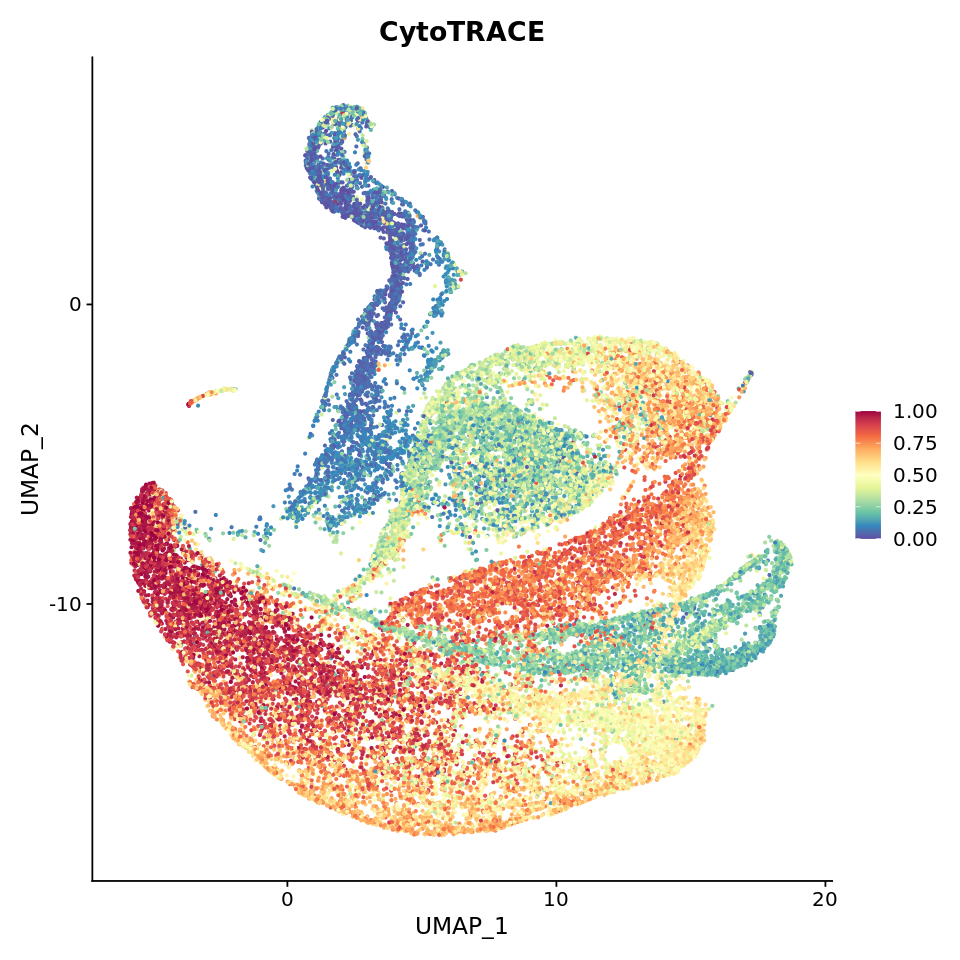

In [31]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(end.cor.integrated, features = "CytoTRACE", pt.size=0.5)+ scale_colour_gradientn(colours = rev(brewer.pal(11,"Spectral")))

In [72]:
saveRDS(end.cor.integrated,'./supp_data/Stele_Atlas.rds')

In [73]:
# Prepare scVelo input
rc.su.counts <- readRDS('./rc.integrated.su.counts_16WT_110K_DR.rds')
rc.su.counts <- subset(rc.su.counts, cells = colnames(rc.su.counts)[end.cor.traj.idx]) 
sr <- rc.su.counts@assays$spliced_RNA@counts
sr <- sr[rownames(end.cor.integrated@assays$integrated@data),]
ur <- rc.su.counts@assays$unspliced_RNA@counts
ur <- ur[rownames(end.cor.integrated@assays$integrated@data),]
ar <- end.cor.integrated@assays$RNA@counts
ar <- ar[rownames(end.cor.integrated@assays$integrated@data),]
sr <- sr/ar;
ur <- ur/ar;
sr <- as.matrix(sr)
ur <- as.matrix(ur)
sr[is.nan(sr)] = 0;
ur[is.nan(ur)] = 0;
colnames(sr) <- colnames(end.cor.integrated)
colnames(ur) <- colnames(end.cor.integrated)
int <- as.matrix(end.cor.integrated@assays$integrated@counts)
#int[which(int < 0)]=0
spliced <- int*sr;
unspliced <- int*ur;
sg <- intersect(rownames(spliced), rownames(unspliced));
spliced <- spliced[match(sg, rownames(spliced)),];
unspliced <- unspliced[match(sg, rownames(unspliced)),];
meta <- end.cor.integrated@meta.data[,grep("time.anno|celltype.anno|time.celltype.anno|CytoTRACE",colnames(end.cor.integrated@meta.data))];
var <- sg;
pca_int <- end.cor.integrated@reductions$pca@cell.embeddings;
umap_int <- end.cor.integrated@reductions$umap@cell.embeddings;
save(spliced, unspliced, meta, var, pca_int, umap_int, file = "./supp_data/Stele_Atlas_scVelo_input.RData")